In [1]:
# import the module
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plot
import seaborn as sns

In [152]:
# this csv comes after running the 'JOBRUNDATA.sql' file and exporting it to csv
jobrundf = pd.read_csv('JOBRUNDATA.csv')

In [153]:
# remove the timedelta part.
jobrundf['START_DATE_TIME'] =  pd.to_datetime(jobrundf['START_DATE_TIME'], format='%d-%m-%y %H:%M:%S')-timedelta(days=20)
jobrundf['NEXT_START_DATE_TIME'] =  pd.to_datetime(jobrundf['NEXT_START_DATE_TIME'], format='%d-%m-%y %H:%M:%S')-timedelta(days=20)

In [154]:
# calculate precision and recall at k
# tp/tp+fp - total predicted +ve
def precision(actual, predicted, top_n):
    act_set = set(actual)
    pred_set = set(predicted[:top_n])
    result = len(act_set & pred_set) / float(top_n)
    return result

# tp/tp+fn - total actual +ve
def recall(actual, predicted, top_n):
    act_set = set(actual)
    pred_set = set(predicted[:top_n])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

In [155]:
jobrundf = pd.DataFrame(columns=["AIML_JOB_RUN_ID", "START_DATE_TIME", "NEXT_START_DATE_TIME"])
new_row = {"AIML_JOB_RUN_ID": 2,
               "START_DATE_TIME": "2020-12-25 01:00:06",
               "NEXT_START_DATE_TIME": "2021-01-02 01:00:06"}

jobrundf = jobrundf.append(new_row,ignore_index=True)
   
new_row = {'AIML_JOB_RUN_ID':3,
               'START_DATE_TIME': '2021-01-02 01:00:06',
               'NEXT_START_DATE_TIME': '2021-01-09 01:00:06'}
jobrundf = jobrundf.append(new_row,ignore_index=True)
    
new_row = {'AIML_JOB_RUN_ID': 4,
               'START_DATE_TIME': '2021-01-09 01:00:06',
               'NEXT_START_DATE_TIME': '2021-01-16 01:00:06'}
jobrundf = jobrundf.append(new_row,ignore_index=True)
    
new_row = {'AIML_JOB_RUN_ID': 5,
               'START_DATE_TIME': '2021-01-16 01:00:06',
               'NEXT_START_DATE_TIME': '2021-01-23 01:00:06'}
jobrundf = jobrundf.append(new_row,ignore_index=True)
    
new_row = {'AIML_JOB_RUN_ID': 6,
               'START_DATE_TIME': '2021-01-23 01:00:06',
               'NEXT_START_DATE_TIME': '2021-01-30 01:00:06'}
jobrundf = jobrundf.append(new_row,ignore_index=True)
    
new_row = {'AIML_JOB_RUN_ID': 7,
               'START_DATE_TIME': '2021-01-30 01:00:06',
               'NEXT_START_DATE_TIME': '2021-02-06 01:00:06'}
jobrundf = jobrundf.append(new_row,ignore_index=True)
    
new_row = {'AIML_JOB_RUN_ID': 8,
               'START_DATE_TIME': '2021-02-06 01:00:06',
               'NEXT_START_DATE_TIME': '2021-02-13 01:00:06'}
jobrundf = jobrundf.append(new_row,ignore_index=True)
    
new_row = {'AIML_JOB_RUN_ID': 9,
               'START_DATE_TIME': '2021-02-13 01:00:06',
               'NEXT_START_DATE_TIME': '2021-02-20 01:00:06'}
jobrundf = jobrundf.append(new_row,ignore_index=True)
    
new_row = {'AIML_JOB_RUN_ID':10,
               'START_DATE_TIME': '2021-02-20 01:00:06',
               'NEXT_START_DATE_TIME':'2021-02-27 01:00:06'}
jobrundf = jobrundf.append(new_row,ignore_index=True)
    
new_row = {'AIML_JOB_RUN_ID':11,
               'START_DATE_TIME': '2021-02-27 01:00:06'}
jobrundf = jobrundf.append(new_row,ignore_index=True)

jobrundf['START_DATE_TIME'] =  pd.to_datetime(jobrundf['START_DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
jobrundf['NEXT_START_DATE_TIME'] =  pd.to_datetime(jobrundf['NEXT_START_DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

In [156]:
jobrundf

,AIML_JOB_RUN_ID,START_DATE_TIME,NEXT_START_DATE_TIME
0,2,2020-12-25 01:00:06,2021-01-02 01:00:06
1,3,2021-01-02 01:00:06,2021-01-09 01:00:06
2,4,2021-01-09 01:00:06,2021-01-16 01:00:06
3,5,2021-01-16 01:00:06,2021-01-23 01:00:06
4,6,2021-01-23 01:00:06,2021-01-30 01:00:06
5,7,2021-01-30 01:00:06,2021-02-06 01:00:06
6,8,2021-02-06 01:00:06,2021-02-13 01:00:06
7,9,2021-02-13 01:00:06,2021-02-20 01:00:06
8,10,2021-02-20 01:00:06,2021-02-27 01:00:06
9,11,2021-02-27 01:00:06,NaT


In [158]:
#finding the last run jobid
maxjobid = jobrundf.AIML_JOB_RUN_ID.max()
print('Last executed jobid: ',maxjobid)

perjobactivity = dict() #dict to keep activity data of each job
perjobrec = dict() #dict to keep hybrid rec for each job
perjobtrend = dict() #dict to keep trending item rec for each job

#check if it next run date for the last job is null, it should be null
if pd.isna(jobrundf[jobrundf['AIML_JOB_RUN_ID']==maxjobid].iat[0,2]):
    #since the last executed job has the most recent activity data hence just importing it
    latestactivitydf = pd.read_csv('./data/jobid'+str(maxjobid)+'/trainingfiles/USER_ACTIVITY_WITH_TIME_PORTAL.csv')
    
    #below part is same as in the original RecommenderSystemForIngramHybridModel.py file
    latestactivitydf.dropna(subset=['PORTALNAME'],inplace=True)

    #Since Download, Pull, Video have are essentially same action, hence combining them
    def combining_activation_download_actions(action):
        if action=='ACTIVATECAMPAIGN':
            return "ACTIVATECAMPAIGN"
        elif action == 'DOWNLOADCAMPAIGN':
            return "ACTIVATECAMPAIGN"        
        else:
            return action
    # Generalizing the activation_download_actions action.
    latestactivitydf['ACTIVITY_TYPE'] = latestactivitydf.apply(lambda x: combining_activation_download_actions(x['ACTIVITY_TYPE']),axis=1)
    #Since we have PDF downloads appended with tactics id, lets generalize them as "Download" action
    def generalizing_actions(action):
        if action.find("DOWNLOAD")>=0:
            return "DOWNLOAD"
        else:
            return action
    # Generalizing the pdf download action.
    latestactivitydf['ACTIVITY_TYPE'] = latestactivitydf.apply(lambda x: generalizing_actions(x['ACTIVITY_TYPE']),axis=1)
    #As we can see that "EnterCampaignStartmarketing" has been done only once, this seems to be a wrong data, lets remove it.
    latestactivitydf = latestactivitydf.loc[latestactivitydf['ACTIVITY_TYPE']!='ENTERCAMPAIGNSTARTMARKETING']
    #Also lets remove the "Close" actions 
    latestactivitydf = latestactivitydf.loc[latestactivitydf['ACTIVITY_TYPE']!='CLOSEASSETPREVIEW']
    latestactivitydf = latestactivitydf.loc[latestactivitydf['ACTIVITY_TYPE']!='CLOSESETUPASSETS']
    #Since Download, Pull, Video have are essentially same action, hence combining them
    def combining_pull_actions(action):
        if action=='VIDEO_GETDEFAULTEMBEDCODE':
            return "PULL"
        elif action == 'DOWNLOAD':
            return "PULL"        
        else:
            return action
    # Combining Download, Pull, Video.
    latestactivitydf['ACTIVITY_TYPE'] = latestactivitydf.apply(lambda x: combining_pull_actions(x['ACTIVITY_TYPE']),axis=1)
    #Similarly EnterCampaignOverview and ReturnCampaignOverivew and EnterCampaignsTab are same kind of action, hence combining them
    def combining_enter_camp_actions(action):
        if action=='ENTERCAMPAIGNSTAB':
            return "ENTERCAMPAIGNOVERVIEW"
        elif action == 'RETURNCAMPAIGNOVERVIEW':
            return "ENTERCAMPAIGNOVERVIEW"   
        elif action == 'ENTERPRODUCT':
            return "ENTERCAMPAIGNOVERVIEW"
        else:
            return action

    # Combining Download, Pull, Video.
    latestactivitydf['ACTIVITY_TYPE'] = latestactivitydf.apply(lambda x: combining_enter_camp_actions(x['ACTIVITY_TYPE']),axis=1)
    
    #these are the unique activities performed by the users
    uniqueactivities = latestactivitydf.ACTIVITY_TYPE.unique().tolist()
    
    #converting timestamp column to datetime type
    latestactivitydf['TIMESTAMP'] =  pd.to_datetime(latestactivitydf['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S')
    
    #if jobid is not the last executed job, fill the three dictionaries based on duration of each recommendation for respective folder
    for index, row in jobrundf.iterrows():
        if row.AIML_JOB_RUN_ID!=maxjobid:
            perjobactivity[row.AIML_JOB_RUN_ID] = latestactivitydf[(latestactivitydf['TIMESTAMP']>row.START_DATE_TIME) & (latestactivitydf['TIMESTAMP']<=row.NEXT_START_DATE_TIME)]
            perjobrec[row.AIML_JOB_RUN_ID] = pd.read_csv('./data/jobid'+str(row.AIML_JOB_RUN_ID)+'/predictionfiles/TOP_HYBRID_REC_FOR_PORTALS_USERS.csv')
            perjobtrend[row.AIML_JOB_RUN_ID] = pd.read_csv('./data/jobid'+str(row.AIML_JOB_RUN_ID)+'/predictionfiles/TOP_TRENDING_PROD_FOR_PORTALS.csv')            
else:
    print("Last job should not have a valid NEXT_START_DATE_TIME")

Last executed jobid:  11


In [82]:
# hardcoded recommendation being shown to US portal users
us_portal = ['NOMADESK BUSINESS FILE SHARING & SYNCHRONIZATION',
'UMBRELLA',
'PICKIT BUSINESS',
'MICROSOFT ENTERPRISE MOBILITY + SECURITY',
'DROPBOX BUSINESS',
'INTERMEDIA OFFICE IN THE CLOUD',
'ACRONIS CYBER CLOUD',
'AUTODESK SOFTWARE COLLECTIONS',
'ITSMINE BEYOND DATA LOSS PREVENTION (DLP)',
'NYOTRON PARANOID',
'MICROSOFT DYNAMICS 365',
'IBM CLOUD',
'WEBEX',
'LETSIGNIT',
'AMAZON WEB SERVICES',
'IBM SPECTRUM PROTECT PLUS',
'SERVICEAIDE LUMA VIRTUAL AGENT',
'SYMANTEC ENDPOINT PROTECTION MOBILE',
'CORENT SURPAAS MAAS',
'IBM SPSS STATISTICS',
'TREND MICRO WORRY-FREE SERVICES',
'PIXM ANTI-PHISHING',
'AVEPOINT MIGRATION',
'ECWID',
'RSIGN',
'MOVERE DISCOVERY',
'MICROSOFT AZURE',
'CLOUDAMIZE',
'CONNECTWISE',
'MICROSOFT WINDOWS 10 ENTERPRISE',
'IBM STORAGE INSIGHTS PRO',
'INTUIT QUICKBOOKS ONLINE',
'STORAGE GUARDIAN BACKUP AND DR SOLUTIONS',
'AVEPOINT CLOUD BACKUP',
'NEW DAY AT WORK WORKSPACE 365',
'VEEAM BACKUP & REPLICATION',
'ACRONIS CYBER BACKUP CLOUD',
'MSPCOMPLETE',
'DROPSUITE EMAIL BACKUP AND ARCHIVING',
'SYMANTEC EMAIL SECURITY.CLOUD',
'VAULT AMERICA CLOUD BACKUP & RECOVERY',
'IBM SPSS MODELER',
'WITTYPARROT',
'LAWTOOLBOX365',
'SYMANTEC CLOUD WORKLOAD PROTECTION',
'EVERNOTE',
'TREND MICRO HOSTED EMAIL SECURITY',
'ESET SECURITY SOLUTIONS',
'YOLA SITEBUILDER',
'ENTRUST DATACARD',
'MICROSOFT 365',
'IBM SPECTRUM SCALE',
'IBM MAAS360 WITH WATSON',
'KASPERSKY ENDPOINT PROTECTION / SECURITY',
'INGRAM MICRO COST OPTIMIZATION SERVICES',
'8X8 X SERIES',
'APC BY SCHNEIDER ELECTRIC - ECOSTRUXURE IT EXPERT',
'SANEBOX',
'IDSYNC IDENTITY SYNCHRONIZER',
'SYMANTEC ENDPOINT PROTECTION CLOUD',
'BITTITAN MIGRATIONWIZ',
'RPOST RMAIL',
'DOCUSIGN BUSINESS PRO CLOUD EDITION',
'DELIVERYSLIP',
'APPTIVO',
'DROPMYSITE WEBSITE BACKUP',
'GOOGLE G SUITE',
'MICROSOFT OFFICE 365',
'NERDIO FOR AZURE',
'TREND MICRO CLOUD APP SECURITY',
'NUANCE POWER PDF ADVANCED',
'RPOST RMAIL']

In [89]:
#declaring a Dataframe which will have all the required column to show the stats
list1 = ["JOB_ID", "ACTIVITY_DATE", "USER_ID", "IS_NEW_USER", "IS_TEST_USER", "PORTAL", "PRECISION@5", "RECALL@5", "PRECISION@10", "RECALL@10", "PRECISION@20", "RECALL@20"]
columns = list1 + uniqueactivities
final_analysis_df = pd.DataFrame(columns=columns)

#filling dataframe for each jobid
for j in perjobactivity.keys():
    for user in perjobactivity[j].USER_ID.unique().tolist():
        isnewuser = 0
        
        istestuser = perjobactivity[j][perjobactivity[j]['USER_ID']==user][:1].iat[0,6]
        portal = perjobactivity[j][perjobactivity[j]['USER_ID']==user][:1].iat[0,4]
        relprod = perjobactivity[j][perjobactivity[j]['USER_ID']==user].ITEM_ID.unique().tolist()
        
        if istestuser == 0:
            #if there is no data in hybrid rec then consider him as a new user
            if len(perjobrec[j][perjobrec[j]['USER_ID']==user].ITEM_ID.tolist())==0:
                isnewuser = 1
            if portal == 'INGRAM US HUB':
                recprod = us_portal.copy()
            else:
                recprod = []
        else:
            recprod = perjobrec[j][perjobrec[j]['USER_ID']==user].ITEM_ID.tolist()
            #if there is no data in hybrid rec then consider him as a new user
            if len(recprod)==0:        
                recprod = perjobtrend[j][perjobtrend[j]['PORTAL']==portal].ITEM_ID.tolist()
                isnewuser = 1
            
        #getting the max time of acitivty, this will help us to compare month by month stats
        activityperiod = perjobactivity[j][perjobactivity[j]['USER_ID']==user].TIMESTAMP.max()
            
        #print('user:', user, 'relprod:', relprod, 'recprod:', recprod)        
        new_row = {'JOB_ID':j,
                   'ACTIVITY_DATE':activityperiod,
                   'USER_ID':user,
                   'IS_NEW_USER':isnewuser,
                   'IS_TEST_USER':istestuser,
                   'PORTAL':portal,               
                   'PRECISION@5':precision(relprod, recprod, top_n = 5),
                   'RECALL@5':recall(relprod, recprod, top_n = 5),
                   'PRECISION@10':precision(relprod, recprod, top_n = 10),
                   'RECALL@10':recall(relprod, recprod, top_n = 10),
                   'PRECISION@20':precision(relprod, recprod, top_n = 20),
                   'RECALL@20':recall(relprod, recprod, top_n = 20)}
        activitycnt = perjobactivity[j][perjobactivity[j]['USER_ID']==user][['ACTIVITY_TYPE','ITEM_ID']].groupby(['ACTIVITY_TYPE'], as_index=False).count()
        for i in uniqueactivities:
            if activitycnt[activitycnt['ACTIVITY_TYPE']==i].shape[0]>0:
                new_row = {**new_row, **{i:activitycnt[activitycnt['ACTIVITY_TYPE']==i].iat[0,1]}}
        final_analysis_df = final_analysis_df.append(new_row,ignore_index=True)

In [90]:
final_analysis_df.head()

,JOB_ID,ACTIVITY_DATE,USER_ID,IS_NEW_USER,IS_TEST_USER,PORTAL,PRECISION@5,RECALL@5,PRECISION@10,RECALL@10,PRECISION@20,RECALL@20,ENTERCAMPAIGNOVERVIEW,PULL,OPENASSETPREVIEW,ACTIVATECAMPAIGN,CAMPAIGNSTATUS,SETUPASSETS
0,2,2020-12-29 05:44:26,119200,0,1,INGRAM ME HUB,0.4,0.666667,0.2,0.666667,0.15,1.0,4,NaN,NaN,2,NaN,NaN
1,2,2020-12-30 12:12:34,125130,1,0,INGRAM US HUB,0.0,0.000000,0.0,0.000000,0.00,0.0,2,NaN,NaN,1,NaN,NaN
2,2,2020-12-28 14:09:44,125895,1,1,INGRAM US HUB,0.0,0.000000,0.0,0.000000,0.05,1.0,2,NaN,NaN,NaN,NaN,NaN
3,2,2020-12-29 12:37:26,129705,1,0,INGRAM US HUB,0.0,0.000000,0.0,0.000000,0.00,0.0,1,NaN,NaN,NaN,NaN,NaN
4,2,2020-12-28 13:25:18,130485,0,0,INGRAM US HUB,0.0,0.000000,0.1,1.000000,0.05,1.0,1,NaN,NaN,NaN,NaN,NaN


In [91]:
#getting US portal data for test and non-test users in two different df grouped by jobid
fad_us_1_perjob = final_analysis_df[(final_analysis_df['PORTAL']=='INGRAM US HUB') & (final_analysis_df['IS_TEST_USER']==1)].groupby(['JOB_ID']).agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})
fad_us_0_perjob = final_analysis_df[(final_analysis_df['PORTAL']=='INGRAM US HUB') & (final_analysis_df['IS_TEST_USER']==0)].groupby(['JOB_ID']).agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})

# Stats for US portal between test and non-test users

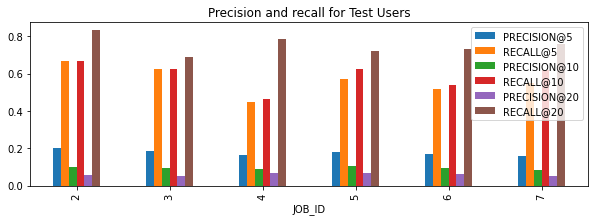

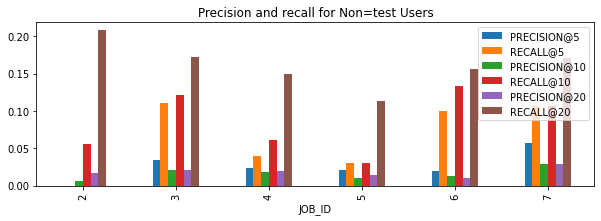

In [121]:
# Please note the range of the two plots could be different
# Comparision of precision and recall for each job
fad_us_1_perjob[['PRECISION@5','RECALL@5','PRECISION@10','RECALL@10','PRECISION@20','RECALL@20']].plot.bar(figsize=(10,3),title='Precision and recall for Test Users')
plot.legend(loc='upper right')

fad_us_0_perjob[['PRECISION@5','RECALL@5','PRECISION@10','RECALL@10','PRECISION@20','RECALL@20']].plot.bar(figsize=(10,3),title='Precision and recall for Non-test Users')
plot.legend(loc='upper right')

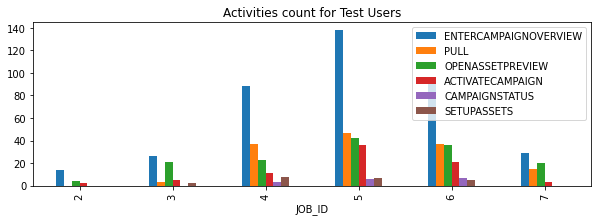

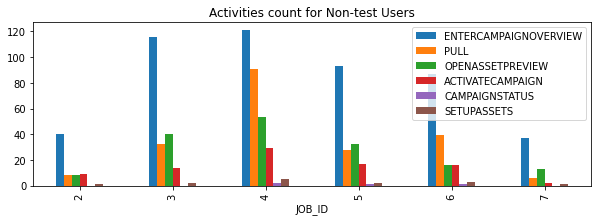

In [122]:
# Please note the range of the two plots could be different
# Comparision of total activities for each job
fad_us_1_perjob[uniqueactivities].plot.bar(figsize=(10,3),title='Activities count for Test Users')
plot.legend(loc='upper right')

fad_us_0_perjob[uniqueactivities].plot.bar(figsize=(10,3),title='Activities count for Non-test Users')
plot.legend(loc='upper right')

<AxesSubplot:title={'center':'Overall count of activities'}>

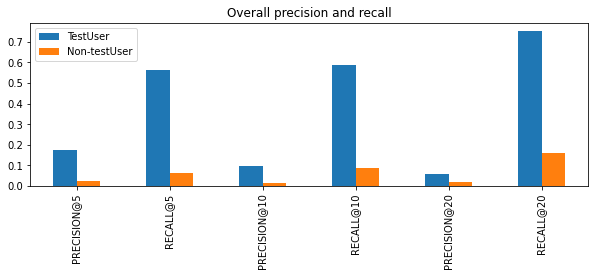

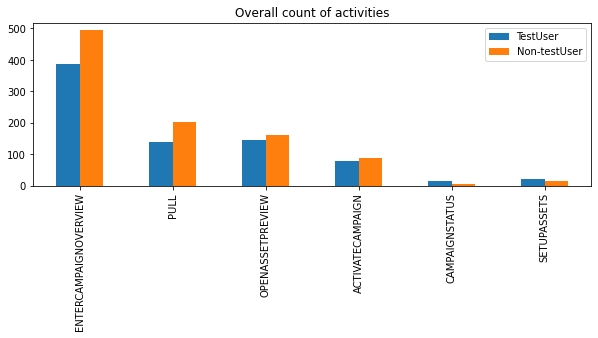

In [125]:
# Comparision of precision and recall and all activities overall
fad_us_1_series = fad_us_1_perjob.agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})
fad_us_0_series = fad_us_0_perjob.agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})
fad_us_1 = pd.DataFrame(fad_us_1_series)
fad_us_0 = pd.DataFrame(fad_us_0_series)

fad_us_merged = pd.merge(fad_us_1, fad_us_0, left_index=True, right_index=True)
fad_us_merged.rename(columns = {'0_x':'TestUser', '0_y':'Non-testUser'}, inplace = True)

fad_us_merged[:6].plot.bar(figsize=(10,3),title='Overall precision and recall')
fad_us_merged[6:].plot.bar(figsize=(10,3),title='Overall count of activities')

# Stats for US portal between test and non-test new users only

In [118]:
fad_us_1_perjob_newuser = final_analysis_df[(final_analysis_df['PORTAL']=='INGRAM US HUB') & (final_analysis_df['IS_TEST_USER']==1) & (final_analysis_df['IS_NEW_USER']==1)].groupby(['JOB_ID']).agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})
fad_us_0_perjob_newuser = final_analysis_df[(final_analysis_df['PORTAL']=='INGRAM US HUB') & (final_analysis_df['IS_TEST_USER']==0) & (final_analysis_df['IS_NEW_USER']==1)].groupby(['JOB_ID']).agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})

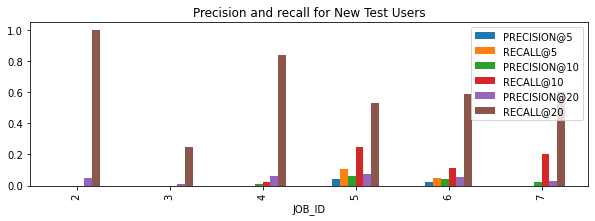

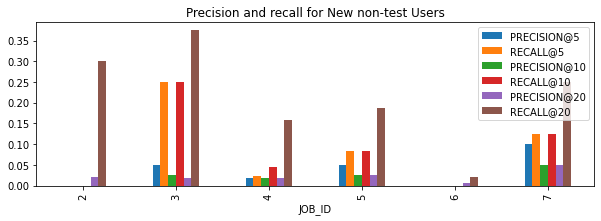

In [124]:
# Please note the range of the two plots could be different
# Comparision of precision and recall for each job for new users
if fad_us_1_perjob_newuser.shape[0]>0:
    fad_us_1_perjob_newuser[['PRECISION@5','RECALL@5','PRECISION@10','RECALL@10','PRECISION@20','RECALL@20']].plot.bar(figsize=(10,3),title='Precision and recall for New Test Users')
    plot.legend(loc='upper right')

if fad_us_0_perjob_newuser.shape[0]>0:
    fad_us_0_perjob_newuser[['PRECISION@5','RECALL@5','PRECISION@10','RECALL@10','PRECISION@20','RECALL@20']].plot.bar(figsize=(10,3),title='Precision and recall for New non-test Users')
    plot.legend(loc='upper right')

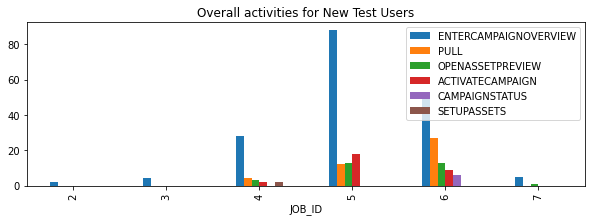

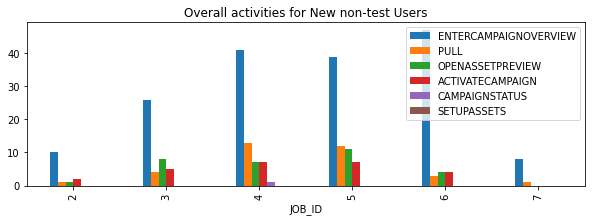

In [126]:
# Please note the range of the two plots could be different
# Comparision of total activities for each job for new users
if fad_us_1_perjob_newuser.shape[0]>0:
    fad_us_1_perjob_newuser[uniqueactivities].plot.bar(figsize=(10,3),title='Overall activities for New Test Users')
    plot.legend(loc='upper right')

if fad_us_0_perjob_newuser.shape[0]>0:
    fad_us_0_perjob_newuser[uniqueactivities].plot.bar(figsize=(10,3),title='Overall activities for New non-test Users')
    plot.legend(loc='upper right')

<AxesSubplot:title={'center':'Overall count of activities for new users'}>

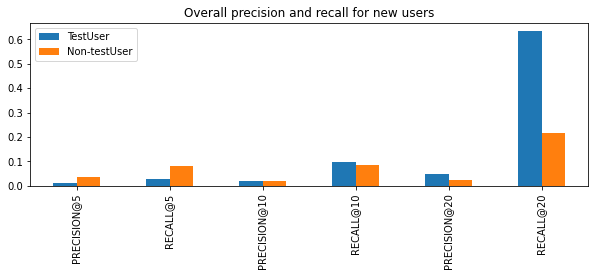

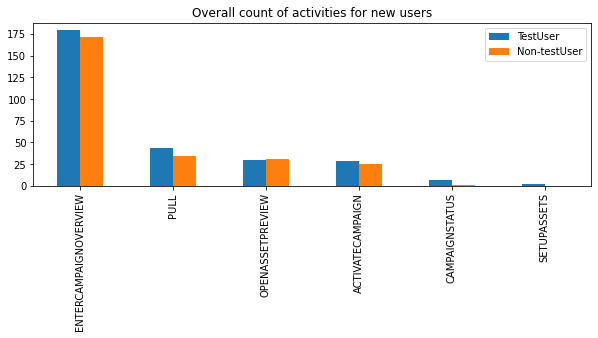

In [127]:
# Comparision of precision and recall and all activities overall for new users
fad_us_1_newuser_series = fad_us_1_perjob_newuser.agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})
fad_us_0_newuser_series = fad_us_0_perjob_newuser.agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})
fad_us_1_newuser = pd.DataFrame(fad_us_1_newuser_series)
fad_us_0_newuser = pd.DataFrame(fad_us_0_newuser_series)

fad_us_merged_newuser = pd.merge(fad_us_1_newuser, fad_us_0_newuser, left_index=True, right_index=True)
fad_us_merged_newuser.rename(columns = {'0_x':'TestUser', '0_y':'Non-testUser'}, inplace = True)

fad_us_merged_newuser[:6].plot.bar(figsize=(10,3),title='Overall precision and recall for new users')
fad_us_merged_newuser[6:].plot.bar(figsize=(10,3),title='Overall count of activities for new users')

# Stats for all portals between test and non-test users

In [99]:
fad_all_1_perjob = final_analysis_df[(final_analysis_df['IS_TEST_USER']==1)].groupby(['PORTAL']).agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})
fad_all_0_perjob = final_analysis_df[(final_analysis_df['IS_TEST_USER']==0)].groupby(['PORTAL']).agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})

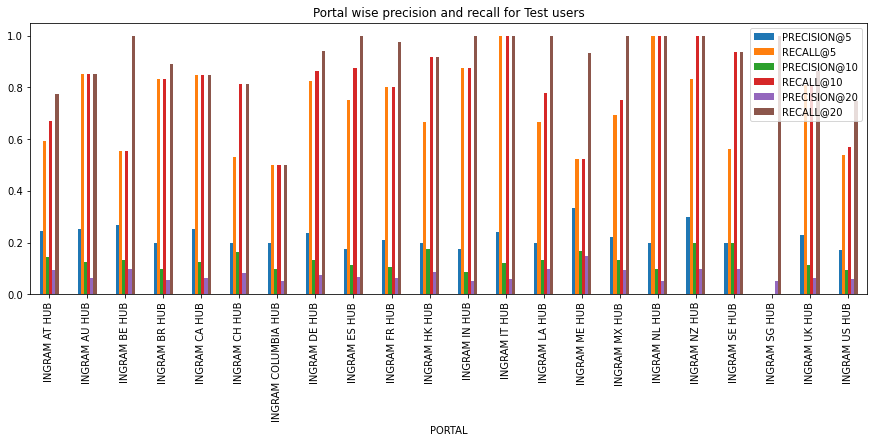

In [128]:
# Precision and recall for all Test user, here are not comparing it with non-test users as item for them appears randombly
fad_all_1_perjob[['PRECISION@5','RECALL@5','PRECISION@10','RECALL@10','PRECISION@20','RECALL@20']].plot.bar(figsize=(15,5),title='Portal wise precision and recall for Test users')
plot.legend(loc='upper right')

In [101]:
fad_all_merged = pd.merge(fad_all_1_perjob[uniqueactivities], fad_all_0_perjob[uniqueactivities], left_index=True, right_index=True)

<ipython-input-147-97ea3efa92ce>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure, axes = plot.subplots(1, 2, figsize=(15, 3))


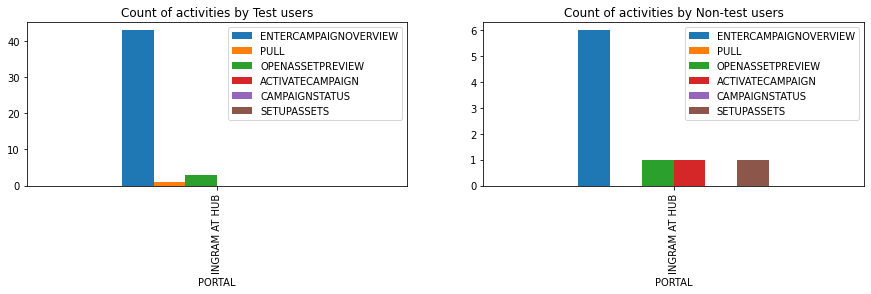

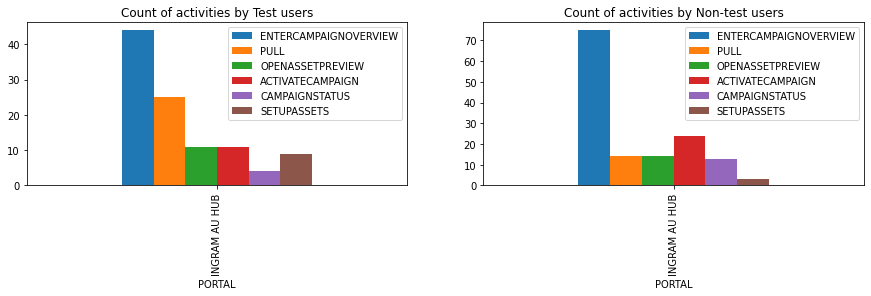

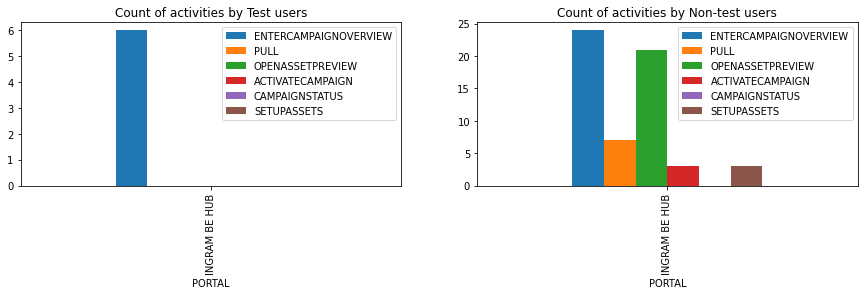

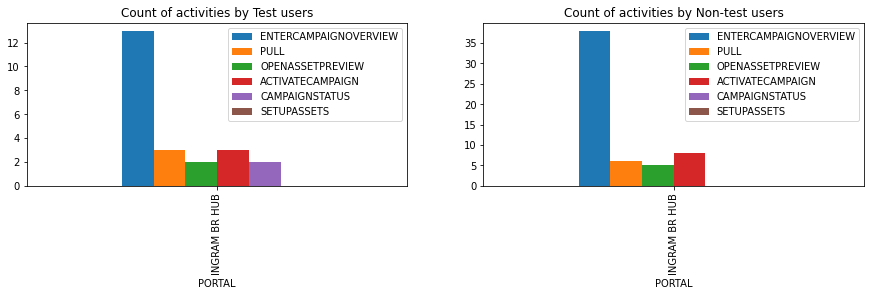

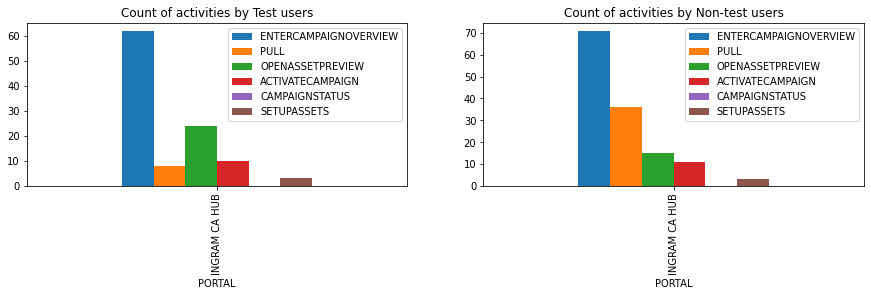

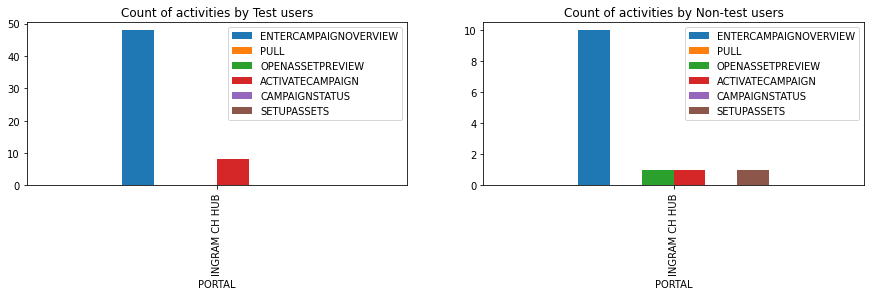

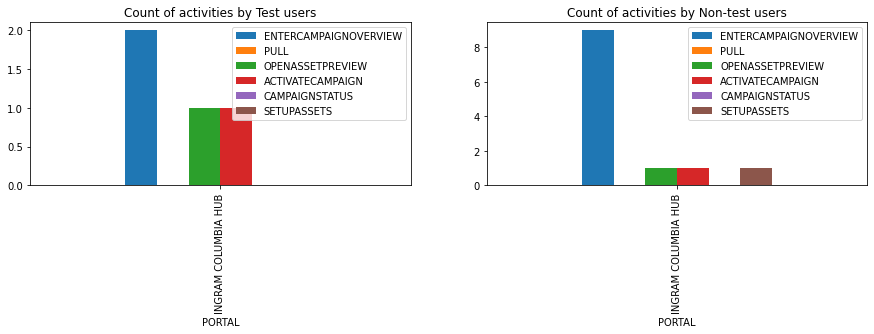

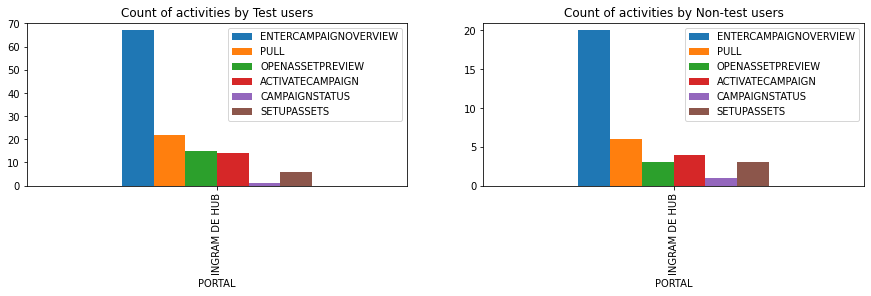

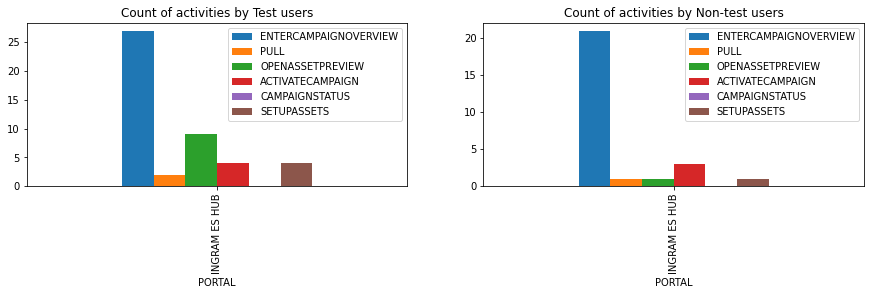

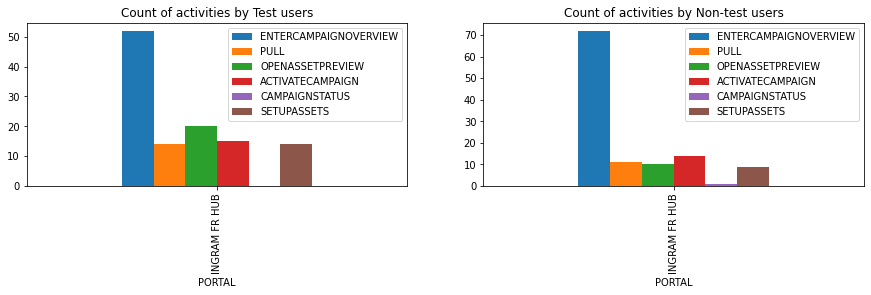

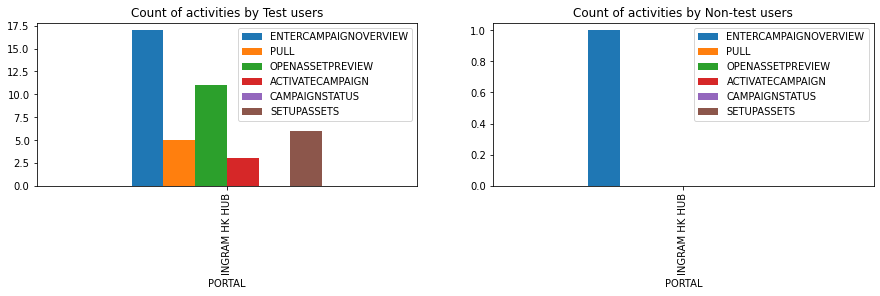

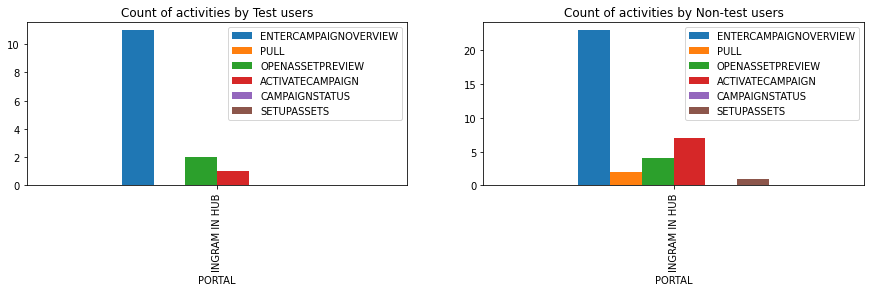

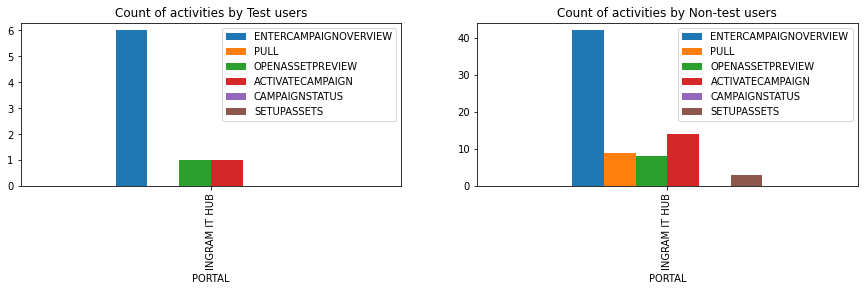

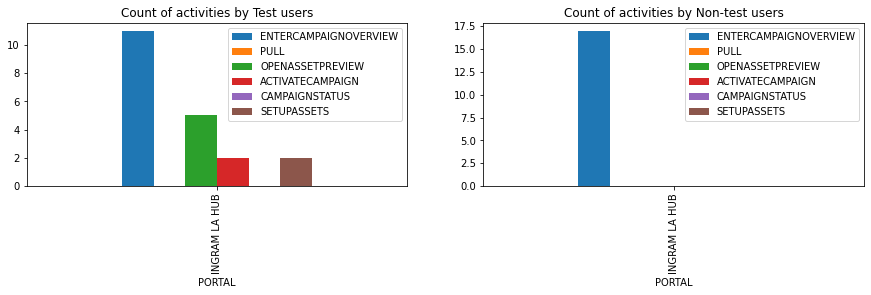

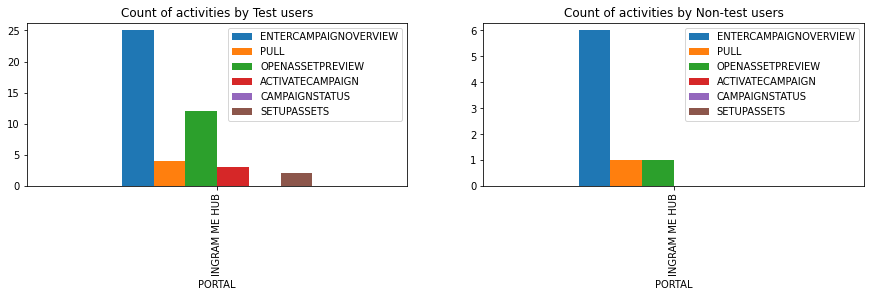

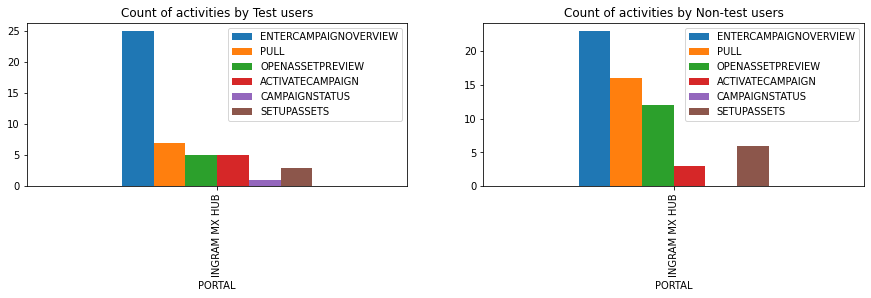

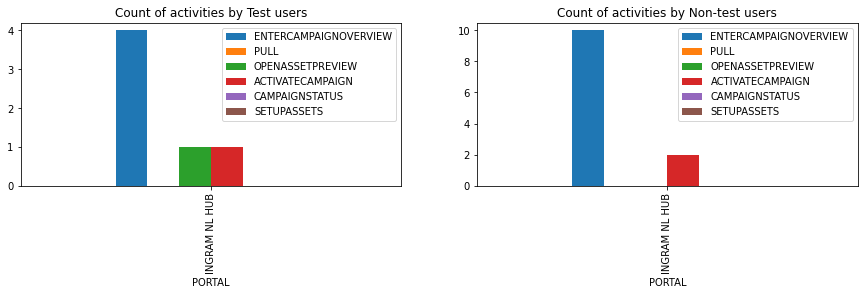

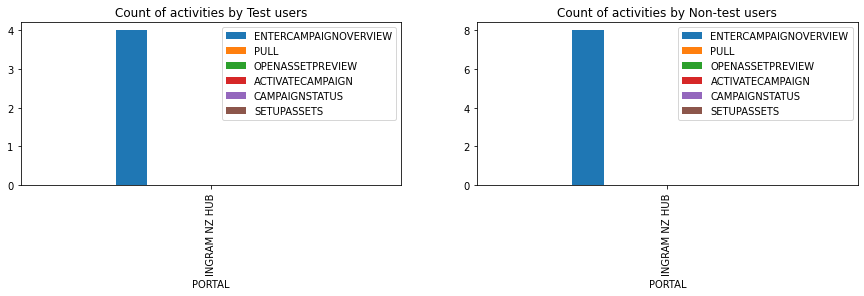

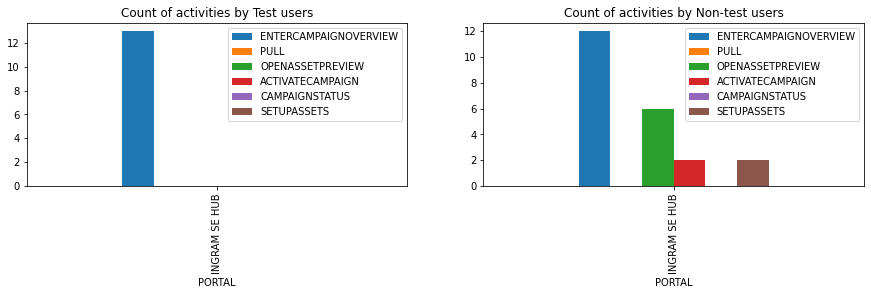

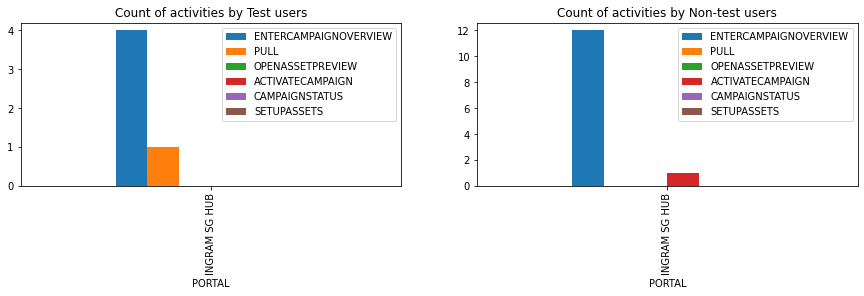

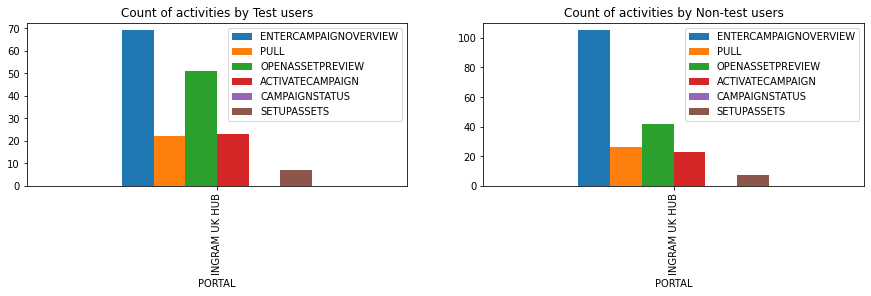

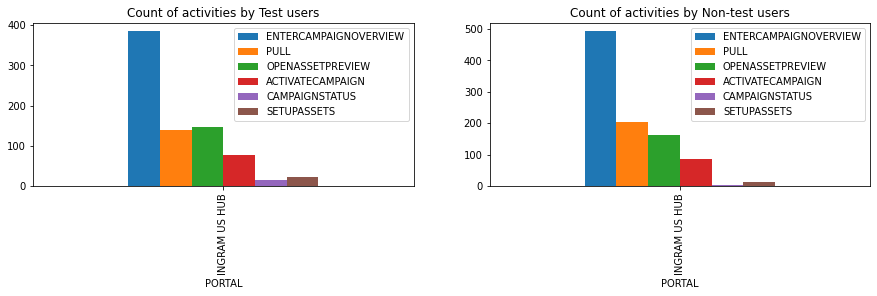

In [147]:
#Portal wise comparision between test and non-test users for all activites
for index, row in fad_all_1_perjob.iterrows():
    figure, axes = plot.subplots(1, 2, figsize=(15, 3))
    if fad_all_1_perjob[uniqueactivities].filter(like = index, axis=0).shape[0] > 0:
        ax1 = fad_all_1_perjob[uniqueactivities].filter(like = index, axis=0).plot.bar(ax=axes[0],title='Count of activities by Test users')        
    if fad_all_0_perjob[uniqueactivities].filter(like = index, axis=0).shape[0] > 0:
        fad_all_0_perjob[uniqueactivities].filter(like = index, axis=0).plot.bar(ax=axes[1],title='Count of activities by Non-test users')

<AxesSubplot:title={'center':'Overall count of activities comparision'}>

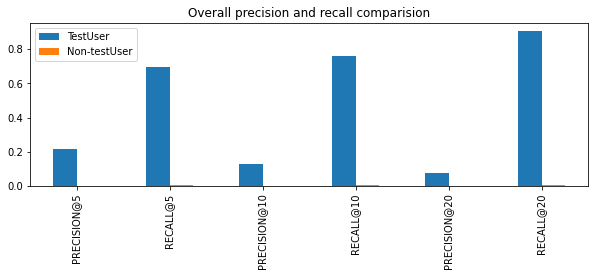

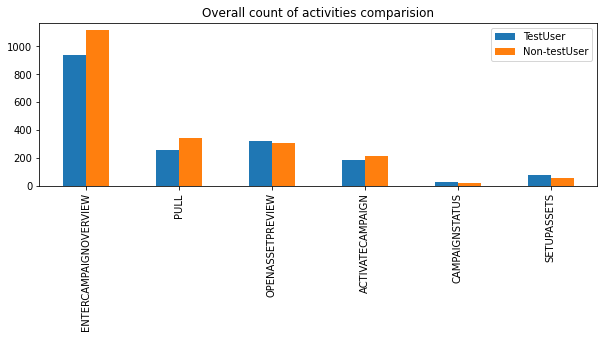

In [131]:
# Comparision of precision and recall and all activities overall
fad_all_1_series = fad_all_1_perjob.agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})
fad_all_0_series = fad_all_0_perjob.agg({'PRECISION@5':'mean', 'RECALL@5':'mean','PRECISION@10':'mean', 'RECALL@10':'mean', 'PRECISION@20':'mean', 'RECALL@20':'mean', 'ENTERCAMPAIGNOVERVIEW':'sum' , 'PULL':'sum', 'OPENASSETPREVIEW':'sum', 'ACTIVATECAMPAIGN':'sum', 'CAMPAIGNSTATUS':'sum', 'SETUPASSETS':'sum'})
fad_all_1 = pd.DataFrame(fad_all_1_series)
fad_all_0 = pd.DataFrame(fad_all_0_series)

fad_all_merged = pd.merge(fad_all_1, fad_all_0, left_index=True, right_index=True)
fad_all_merged.rename(columns = {'0_x':'TestUser', '0_y':'Non-testUser'}, inplace = True)

fad_all_merged[:6].plot.bar(figsize=(10,3),title='Overall precision and recall comparision')
fad_all_merged[6:].plot.bar(figsize=(10,3),title='Overall count of activities comparision')

# Returning user comparision between test and non-test users

In [114]:
df_session_analysis = latestactivitydf[['USER_ID','LIBTRACKINGSESSIONID','ITEM_ID','IS_AIML_TEST_USER']].groupby(['USER_ID','LIBTRACKINGSESSIONID','IS_AIML_TEST_USER'], as_index=False).count()
df_session_analysis = df_session_analysis[['USER_ID','LIBTRACKINGSESSIONID','IS_AIML_TEST_USER']].groupby(['USER_ID','IS_AIML_TEST_USER'],as_index=False).count()

[Text(0, 0, 'Test users'), Text(1, 0, 'Non-test users')]

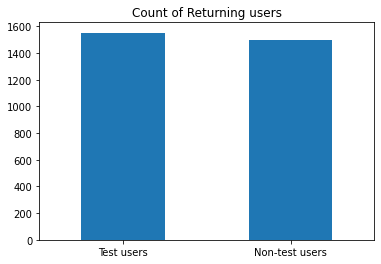

In [145]:
#returning users
ret_user_plot = df_session_analysis[df_session_analysis['LIBTRACKINGSESSIONID']>1]['IS_AIML_TEST_USER'].value_counts().plot.bar(title='Count of Returning users')
ret_user_plot.set_xticklabels( ('Test users', 'Non-test users'),rotation=0)